# analysis of DNA-MERFISH for CTP11

by Pu Zheng

2021.11.10

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_5\20211108-P_brain_CTP11-1000_DNA_only



# 0. Load basic functions

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

7328


In [2]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(get_img_info)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

<module 'ImageAnalysis3.spot_tools.fitting' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\spot_tools\\fitting.py'>

# 1. Pre-processing

In [3]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_5\20211108-P_brain_CTP11-1000_DNA_only',
             'save_folder':r'\\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only',
             'experiment_type': 'DNA',
             'num_threads': 26,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor',
             'shared_parameters':{
                     'single_im_size':[60,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':True,
                     'min_num_seeds':500,
                     'max_num_seeds': None,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':True
                 }, 
             }


In [4]:
_fov_id = 5
_overwrite = False

#for _fov_id in np.arange(5, 45):

# create fov class
fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                          _color_info_kwargs={
                                              '_color_filename':'Color_Usage',
                                          }, 
                                          _prioritize_saved_attrs=False,
                                          _save_info_to_file=False, # set this to be false when hdf5 already exists
                                          )

# 2. Process image into candidate spots
fov.parallel=True
fov.combo_ref_id = 0

fov._process_image_to_spots('combo', 
                            _load_common_reference=True, _load_with_multiple=False,
                            _save_images=True,
                            _warp_images=False, 
                            _fit_spots=True,
                            _overwrite_drift=_overwrite, _overwrite_image=_overwrite,
                            _overwrite_spot=_overwrite,
                            _verbose=True)
# 3. Load DAPI image
dapi_im = fov._load_dapi_image()


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 53
- Number of field of views: 60
- Importing csv format color_usage file: \\10.245.74.158\Chromatin_NAS_5\20211108-P_brain_CTP11-1000_DNA_only\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25C50', 'H26C26', 'H27C27', 'H28C28', 'H29C29', 'H30C30', 'H31C31', 'H32C32', 'H33C33', 'H34C34', 'H35C35', 'H36C36', 'H37C37', 'H38C38', 'H39C39', 'H40C40', 'H41C41', 'H42C42', 'H43C43', 'H44C44', 'H45C45', 'H46C46', 'H47C47', 'H48C48', 'H49C49', 'H50P1', 'H51C38_c74', 'H52C38_c75'])
- 53 folders are found according to color-usage annotation.
+ loading fov_info from file: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Conv_zscan_05.hdf5
++ base att

## check drifts

In [ ]:
sel_bits = [9,45,66]
bead_ims = fov._load_bead_ims_for_bits(sel_bits, 'combo')

In [ ]:
visual_tools.imshow_mark_3d_v2(bead_ims)

# 2. Partiton spots into cells

In [5]:
save_folder = fov_param['save_folder']
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
print(len(save_filenames))

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

42
Use segmentation_folder: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots


## 2.1 run segmentation

In [6]:
_save_filename = [_fl for _fl in save_filenames \
                  if int( os.path.basename(_fl.split('.hdf5')[0].split('_')[-1]) ) == _fov_id]
print(f"{len(_save_filename)} matched save_files found for fov: {_fov_id}")
_save_filename = _save_filename[0]
print(_save_filename)

1 matched save_files found for fov: 5
\\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Conv_zscan_05.hdf5


### load DAPI and spots

In [7]:
with h5py.File(_save_filename, "r", libver='latest') as _f:

    _segment_fov_id = _f.attrs['fov_id']
    _segment_fov_name = _f.attrs['fov_name']
    
    # load PolyT if applicable
    if 'protein' in _f:
        polyt_im = _f['protein']['ims'][0]
    else:
        polyt_im = None
    # load DAPI
    dapi_im = _f.attrs['dapi_im']
    # load spots and parameters
    parameters = ast.literal_eval(_f.attrs['shared_parameters']) 
    
    _grp = _f['combo']
    combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['spots'][:]]
    raw_combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['raw_spots'][:]]
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]

In [8]:
pixel_sizes = parameters['distance_zxy']
single_im_size = parameters['single_im_size']

segmentation_filename = os.path.join(segmentation_folder, 
                                     os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.npy') )

if os.path.exists(segmentation_filename):
    print(f"directly load segmentation from file: {segmentation_filename}")
    _mask = np.load(segmentation_filename)

else:
    visual_tools.imshow_mark_3d_v2([dapi_im])
    seg_class = ia.segmentation_tools.cell.Cellpose_Segmentation_3D(dapi_im, polyt_im, pixel_sizes,
                                                                    save_filename=segmentation_filename,
                                                                    )

    _mask = seg_class.run()
    seg_class.save()
    seg_class.clear()

directly load segmentation from file: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Segmentation\Conv_zscan_05_Segmentation.npy


<IPython.core.display.Javascript object>


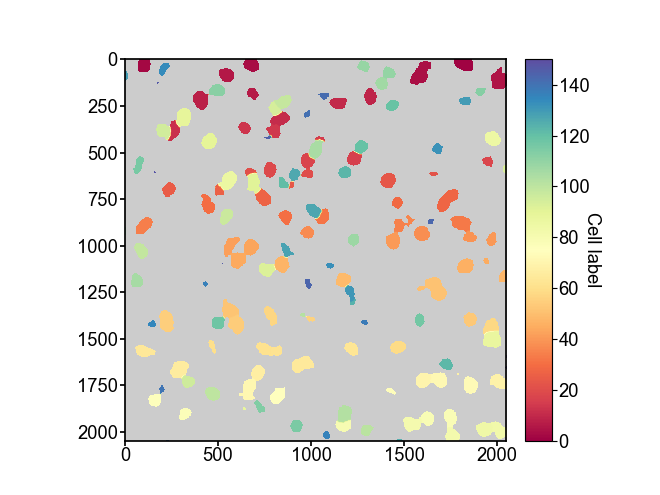

-- save iamage to file: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Segmentation\Figures\Conv_zscan_05_SegmentationMask.png


In [9]:
from ImageAnalysis3.figure_tools import plot_segmentation
mask_savefig = os.path.join(segmentation_folder, 'Figures', _segment_fov_name.replace('.dax', '_SegmentationMask.png'))
if not os.path.exists(os.path.dirname(mask_savefig)):
    os.makedirs(os.path.dirname(mask_savefig))
    
ax = plot_segmentation.plot_segmentation(_mask, save_filename=mask_savefig)

## 2.2 Partition spots

In [10]:
if '_mask' in locals():
    seg_label = _mask
else:
    seg_label = np.load(segmentation_filename)

In [12]:
from ImageAnalysis3.meta_tools.partition_spots import Spots_Partition
reload(ia.meta_tools.partition_spots)
from ImageAnalysis3.classes.preprocess import Spots3D

In [17]:
%%time

#dapi_th = 3000
search_radius = 8

num_labels = np.max(seg_label)
cell_2_spots = {_c:{} for _c in np.arange(1, num_labels+1)}
cell_2_raw_spots = {_c:{} for _c in np.arange(1, num_labels+1)}

label_dict = {}
#signal_dict = {}

for _id, _pts, _raw_pts in zip(combo_ids, combo_spots_list, raw_combo_spots_list):
    # cast spot class
    _spots = Spots3D(_pts, bits=_id, pixel_sizes=pixel_sizes)
    _raw_spots = Spots3D(_pts, bits=_id, pixel_sizes=pixel_sizes)
    
    # calculate labels
    _labels = Spots_Partition.spots_to_labels(seg_label, _spots, search_radius=search_radius)
    #_signals = Spots_Partition.spots_to_DAPI(dapi_im, _spots, search_radius=search_radius)
    
    label_dict[_id] = _labels
    #signal_dict[_id] = _signals
    # parittion
    for _l in np.unique(_labels):
        if _l > 0:
            #_keep_flags = (_labels==_l) * (_signals > dapi_th)
            _keep_flags = (_labels==_l)
            # append
            cell_2_spots[_l][_id] = _spots[_keep_flags]
            cell_2_spots[_l][_id].bits = _spots.bits[_keep_flags]
            cell_2_raw_spots[_l][_id] = _raw_spots[_keep_flags]
            cell_2_raw_spots[_l][_id].bits = _raw_spots.bits[_keep_flags]   


-- partition barcodes for 9920 spots
-- partition barcodes for 12200 spots
-- partition barcodes for 9828 spots
-- partition barcodes for 13482 spots
-- partition barcodes for 10041 spots
-- partition barcodes for 11664 spots
-- partition barcodes for 10501 spots
-- partition barcodes for 12686 spots
-- partition barcodes for 10478 spots
-- partition barcodes for 13027 spots
-- partition barcodes for 9891 spots
-- partition barcodes for 12603 spots
-- partition barcodes for 9842 spots
-- partition barcodes for 11632 spots
-- partition barcodes for 10508 spots
-- partition barcodes for 12413 spots
-- partition barcodes for 10592 spots
-- partition barcodes for 12393 spots
-- partition barcodes for 9994 spots
-- partition barcodes for 12493 spots
-- partition barcodes for 9250 spots
-- partition barcodes for 12225 spots
-- partition barcodes for 9847 spots
-- partition barcodes for 12389 spots
-- partition barcodes for 10189 spots
-- partition barcodes for 12195 spots
-- partition barcod

## plot number of spots per bits per cell

<IPython.core.display.Javascript object>


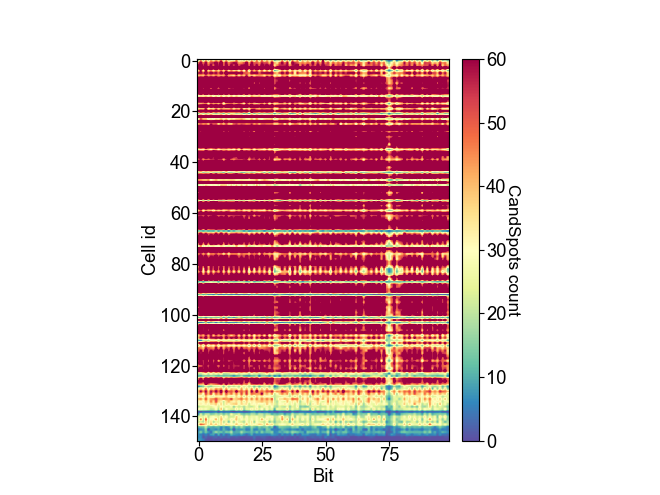

-- save iamage to file: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Figures\Conv_zscan_05_SpotCountPerCell.png


In [18]:
from ImageAnalysis3.figure_tools import plot_partition

cell_spots_counts = []
for _cell, _spots_dict in cell_2_spots.items():
    _spots_counts = []
    for _bit in combo_ids:
        if _bit in _spots_dict:
            _spots_counts.append(len(_spots_dict[_bit]))
        else:
            _spots_counts.append(0)
    cell_spots_counts.append(np.array(_spots_counts))
cell_spots_counts = np.array(cell_spots_counts)

count_savefig = os.path.join(cand_spot_folder, 'Figures', 
                             _segment_fov_name.replace('.dax', '_SpotCountPerCell.png'))
if not os.path.exists(os.path.dirname(count_savefig)):
    os.makedirs(os.path.dirname(count_savefig))
# Plot
count_ax = plot_partition.plot_cell_spot_counts(cell_spots_counts, save=True, save_filename=count_savefig)

## 2.3 save partitioned spots

In [19]:
from ImageAnalysis3.classes import decode
import pandas as pd

bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

In [20]:
columns = ['fov_id', 'cell_id',]
# add spot info
spot_infos = ['height', 'z', 'x', 'y', 'background', 'sigma_z', 'sigma_x', 'sigma_y', 'sin_t', 'sin_p', 'eps']
columns.extend(spot_infos)
# add bits
columns.extend(['bit', 'channel'])
# add pixel
pixel_infos = ['pixel_z', 'pixel_x', 'pixel_y']
columns.extend(pixel_infos)

In [21]:
%%time
# add info to spots_df
_spot_info_list = []
for _cell_id, _spot_dict in cell_2_spots.items():
    for _bit, _spots in _spot_dict.items():
        for _spot, _bit in zip(_spots, _spots.bits):
            _spot_info = [_segment_fov_id, _cell_id]
            _spot_info.extend(list(_spot))
            _spot_info.extend([_bit, bit_2_channel[_bit]])
            _spot_info.extend(list(pixel_sizes))
            # append
            _spot_info_list.append(_spot_info)

Wall time: 15.1 s


In [22]:
# create dataframe
spots_df = pd.DataFrame(_spot_info_list, columns=columns)

In [23]:
cand_spot_filename = os.path.join(cand_spot_folder, _segment_fov_name.replace('.dax', f'_CandSpots.csv') )
print(cand_spot_filename)
spots_df.to_csv(cand_spot_filename)

\\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots\Conv_zscan_05_CandSpots.csv


In [24]:
spots_df

,fov_id,cell_id,height,z,x,y,background,sigma_z,sigma_x,sigma_y,sin_t,sin_p,eps,bit,channel,pixel_z,pixel_x,pixel_y
0,5,1,4906.597168,18.245514,39.267925,1862.509277,131.811981,2.210023,1.627333,3.481306,0.821883,1.000000,396.753479,1,750,250,108,108
1,5,1,4643.417480,10.314692,41.279716,1846.413696,335.529449,1.596332,1.619538,1.807225,-1.000000,-1.000000,398.631775,1,750,250,108,108
2,5,1,4197.027344,4.641076,33.987762,1803.783569,212.504715,1.508265,1.466107,1.570249,-1.000000,-1.000000,384.614044,1,750,250,108,108
3,5,1,3549.138672,11.696331,16.159897,1821.808838,56.006660,2.984957,1.695028,1.546912,0.624736,0.577108,184.156265,1,750,250,108,108
4,5,1,3460.828125,16.303942,38.477371,1792.406494,73.939888,1.478751,1.436194,2.858066,0.499568,-0.772950,159.519104,1,750,250,108,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891429,5,150,1858.118774,47.024075,1613.297241,2033.847778,84.410576,3.210406,1.599084,1.746133,-0.192404,0.480226,144.672729,47,750,250,108,108
891430,5,150,2336.701416,36.738781,1582.994141,2032.035400,35.517899,2.890990,1.717606,2.909941,-0.067508,1.000000,226.445984,49,750,250,108,108
891431,5,150,2182.086182,48.656059,1577.868042,2036.458496,75.991249,3.652952,1.579572,1.383026,-0.006558,0.125156,172.495789,52,647,250,108,108
891432,5,150,1384.946167,47.913479,1609.103760,2032.536987,124.172256,3.745082,1.369088,1.120612,-0.431920,0.194430,172.665924,55,750,250,108,108


# 3. Test Decoding

## 3.1 load codebook

In [25]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910,chr,chr_order
0,1:3740000-3760000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:6240000-6260000,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1:8740000-8760000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,1:11240000-11260000,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,1:13740000-13760000,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,X:161240000-161260000,1057,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,X,52
984,X:163740000-163760000,1058,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,X,53
985,X:166240000-166260000,1059,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,X,54
986,X:168740000-168760000,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,55


## 3.2 load spot files

In [51]:
debug = True

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
print(decoder_folder)

\\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Decoder\v5


In [182]:
spots_df = pd.read_csv(
    os.path.join(cand_spot_folder, 
                 _segment_fov_name.replace('.dax', f'_CandSpots.csv')),
)

In [136]:
bit_2_channel = {}
for _b in np.unique(spots_df['bit']):
    _ch = np.unique(spots_df.loc[spots_df['bit']==_b, 'channel'])
    bit_2_channel[_b] = str(_ch[0])

## 3.3 test decode one cell

In [220]:
%%time
from ImageAnalysis3.classes import decode
reload(decode)
overwrite = True

overwrite_decoder = True
pair_search_radius = 250

decode_args = []

for _cell_id in np.unique(spots_df['cell_id']):
    _cell_spots_df = spots_df[spots_df['cell_id']==_cell_id]
    _decoder_filename = os.path.join(decoder_folder, _fov_name.replace('.dax', f'_Cell-{_cell_id}_Decoder.pkl'))
    _args = (_cell_spots_df, codebook_df, _decoder_filename, 
             False, True, bit_2_channel,
             pixel_sizes, 2, 0.4, 
             pair_search_radius, -1, 1, 5, 0, -25, 
             False, overwrite_decoder, True, False) 
    # append
    decode_args.append(_args)
print(len(decode_args))

150
Wall time: 291 ms


- 8853 pairs kept given search radius 250 nm.
- search spot_groups given search radius 250 nm, max_usage=1


100%|███████████████████████████████████████████████████████████████| 8853/8853 [00:00<00:00, 119545.97it/s]


- 2656 spot_groups detected
- split found tuples into chromosomes. 
- generate randomized spot pairs 
- generate chr_2_kdtree. 
-- seeding chr:1 with 77 regions with 180 spot_groups
- diff in iter-0: 0.5889
- diff in iter-1: 0.0167
- diff in iter-2: 0.0000
-- seeding chr:10 with 51 regions with 122 spot_groups
- diff in iter-0: 0.6557
- diff in iter-1: 0.1066
- diff in iter-2: 0.0000
-- seeding chr:11 with 48 regions with 133 spot_groups
- diff in iter-0: 0.5564
- diff in iter-1: 0.0376
- diff in iter-2: 0.0000
-- seeding chr:12 with 43 regions with 137 spot_groups
- diff in iter-0: 0.4161
- diff in iter-1: 0.1606
- diff in iter-2: 0.1168
- diff in iter-3: 0.0365
- diff in iter-4: 0.0219
- diff in iter-5: 0.0146
- diff in iter-6: 0.0292
- diff in iter-7: 0.0292
- diff in iter-8: 0.0000
-- seeding chr:13 with 45 regions with 118 spot_groups
- diff in iter-0: 0.5847
- diff in iter-1: 0.1271
- diff in iter-2: 0.1186
- diff in iter-3: 0.0508
- diff in iter-4: 0.0000
-- seeding chr:14 with 

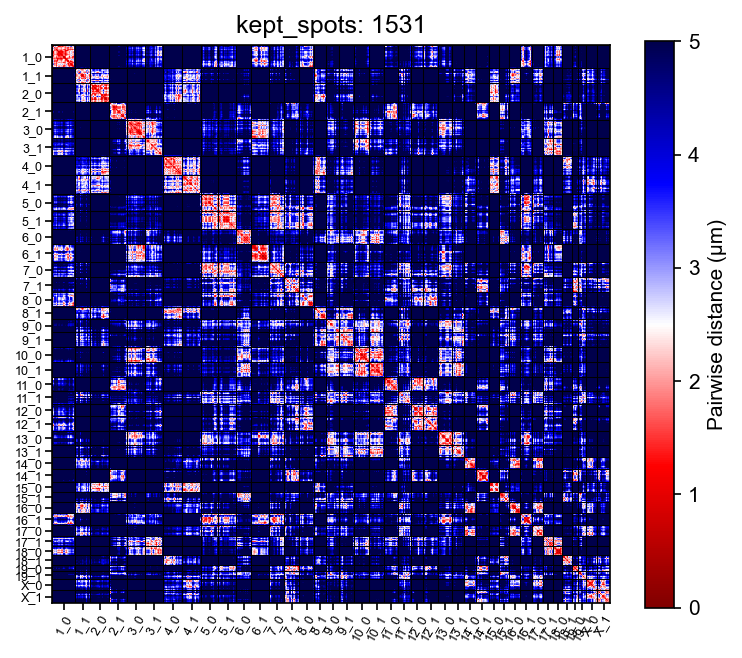

In [184]:
# test run one cell
%matplotlib inline
reload(decode)

decoder = decode.batch_decode_DNA(*decode_args[10])

In [221]:
sc,dc = 0,0
for _ig, _group in enumerate(decoder.spot_groups):
    #print(_ig, _group.bits)
    if combo_channels[_group.bits[0]-1] == combo_channels[_group.bits[1]-1]:
        sc += 1
    else:
        dc += 1
print(sc,dc)

1524 1132


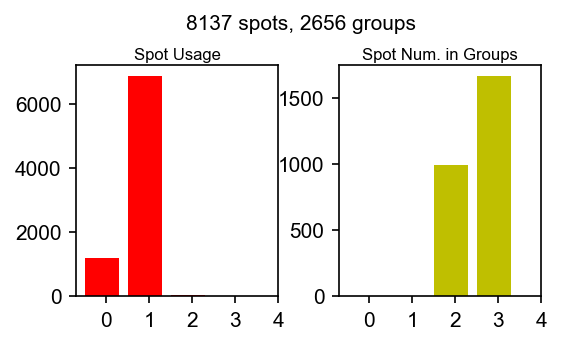

In [185]:
from ImageAnalysis3.figure_tools import plot_decode
reload(figure_tools.plot_decode)
plot_decode.plot_spot_stats(decoder.spot_groups, decoder.spot_usage,
                            show_image=False)

## visualize decoded spots

In [222]:
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Use decoder_folder: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Decoder\v5
Creating decode_figure_folder: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Decoder\v5\Figures


## load images

This step is slow because all images are ~50GB

In [187]:
%%time
with h5py.File(_save_filename, "r", libver='latest') as _f:
    _fov_name = _f.attrs['fov_name']
    _grp = _f['combo']
    combo_ims = _grp['ims'][:]
    combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['spots'][:]]
    raw_combo_spots_list = [_spots[_spots[:,0]>0] for _spots in _grp['raw_spots'][:]]
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]
    combo_drifts = _grp['drifts'][:]

Wall time: 1min 15s


In [137]:
# generate shift function for all bits
from ImageAnalysis3.correction_tools.chromatic import generate_chromatic_function

bit_2_shift_func = {}
for _bit, _ch, _dft in zip(combo_ids, combo_channels, combo_drifts):
    _func = generate_chromatic_function(fov.correction_profiles['chromatic_constants'][_ch], drift=_dft)
    bit_2_shift_func[_bit] = _func

In [223]:
from tqdm import tqdm
_group_id = 0

reload(io_tools.crop)
sel_group = decoder.spot_groups[_group_id]
#sel_group = decoder.spot_groups[2000]

crop_size=4

print(sel_group.bits)

_centroid = sel_group.centroid_spot().to_coords()
_bit_2_centroid = np.concatenate([bit_2_shift_func[_bit](_centroid)
                                  for _bit in combo_ids])
_bit_2_centroid =  2*_centroid - _bit_2_centroid
# for given spot group, generate corresponding crops
cropped_ims = []
if 'combo_ims' in locals():
    for _ind, _im in enumerate(combo_ims):
        # generate slice
        _crop = io_tools.crop.generate_neighboring_crop(_bit_2_centroid[_ind], crop_size, parameters['single_im_size']).to_slices()
        cropped_ims.append(_im[_crop])
else:
    with h5py.File(_save_filename, "r", libver='latest') as _f:
        _grp = _f['combo']
        _ids = _grp['ids'][:]
        for _ind, _bit in enumerate(_ids):
            # generate slice
            _crop = io_tools.crop.generate_neighboring_crop(_bit_2_centroid[_ind], crop_size, parameters['single_im_size']).to_slices()
            # directly load cropped image
            cropped_im = _grp['ims'][_ind][_crop]
            cropped_ims.append(cropped_im)
    
_rid = decoder.valid_bit_pair_2_region[tuple(sel_group.bits[:2])]
print(sel_group.bits, _rid)
_code = decoder.valid_region_2_bits[_rid]
print(_code)
_positive_ims = [_im for _bit,_im in zip(combo_ids, cropped_ims) if _bit in sel_group.bits]
max_th = np.max(_positive_ims) 
_title = f"Decoded pair {sel_group.bits} with code={_code}"

if hasattr(sel_group, 'final_score'):
    _title += f", score={sel_group.final_score:.3f}"

_sel_bit_2_coords = {}
_sel_bit_2_usage = {}
_bit_2_raw_spots = {}

for _bit in tqdm(decoder.bits):
    # select spots
    _bit_spots = decoder.cand_spots[decoder.cand_spots.bits==_bit]
    
    _matched_raw_pts = []
    for _spot in _bit_spots:
        _ibit = list(decoder.bits).index(_bit)
        # find matching raw spots
        _raw_spot_ind = np.where(np.linalg.norm(raw_combo_spots_list[_ibit][:,4:] - _spot[4:], axis=1)<1e-5)[0]
        _matched_raw_pts.append(raw_combo_spots_list[_ibit][_raw_spot_ind])
    _matched_raw_spots = Spots3D(np.concatenate(_matched_raw_pts), 
                                 bits=_bit, pixel_sizes=decoder.pixel_sizes)
    
    # select
    _sel_flag = np.linalg.norm(_matched_raw_spots.to_coords() - _bit_2_centroid[_ibit], axis=1, ord=np.inf) < (crop_size+0.5)
    _sel_bit_2_coords[_bit] = _matched_raw_spots.to_coords()[_sel_flag] - _bit_2_centroid[_ibit] + crop_size
    
    _local_coord_usage = decoder.spot_usage[decoder.cand_spots.bits==_bit]
    _sel_bit_2_usage[_bit] = _local_coord_usage[_sel_flag]
    
    _bit_2_raw_spots[_bit] = _matched_raw_spots[_sel_flag]
    
decode_fig_filename = os.path.join(decode_figure_folder, f"{_fov_name.replace('.dax', '')}_Cell-{_cell_id}_decode-{_group_id}.png")


  2%|█▍                                                                      | 2/99 [00:00<00:05, 19.03it/s]

[62 96 94]
[62 96 94] 850
(62, 94, 96)


100%|███████████████████████████████████████████████████████████████████████| 99/99 [00:04<00:00, 20.88it/s]


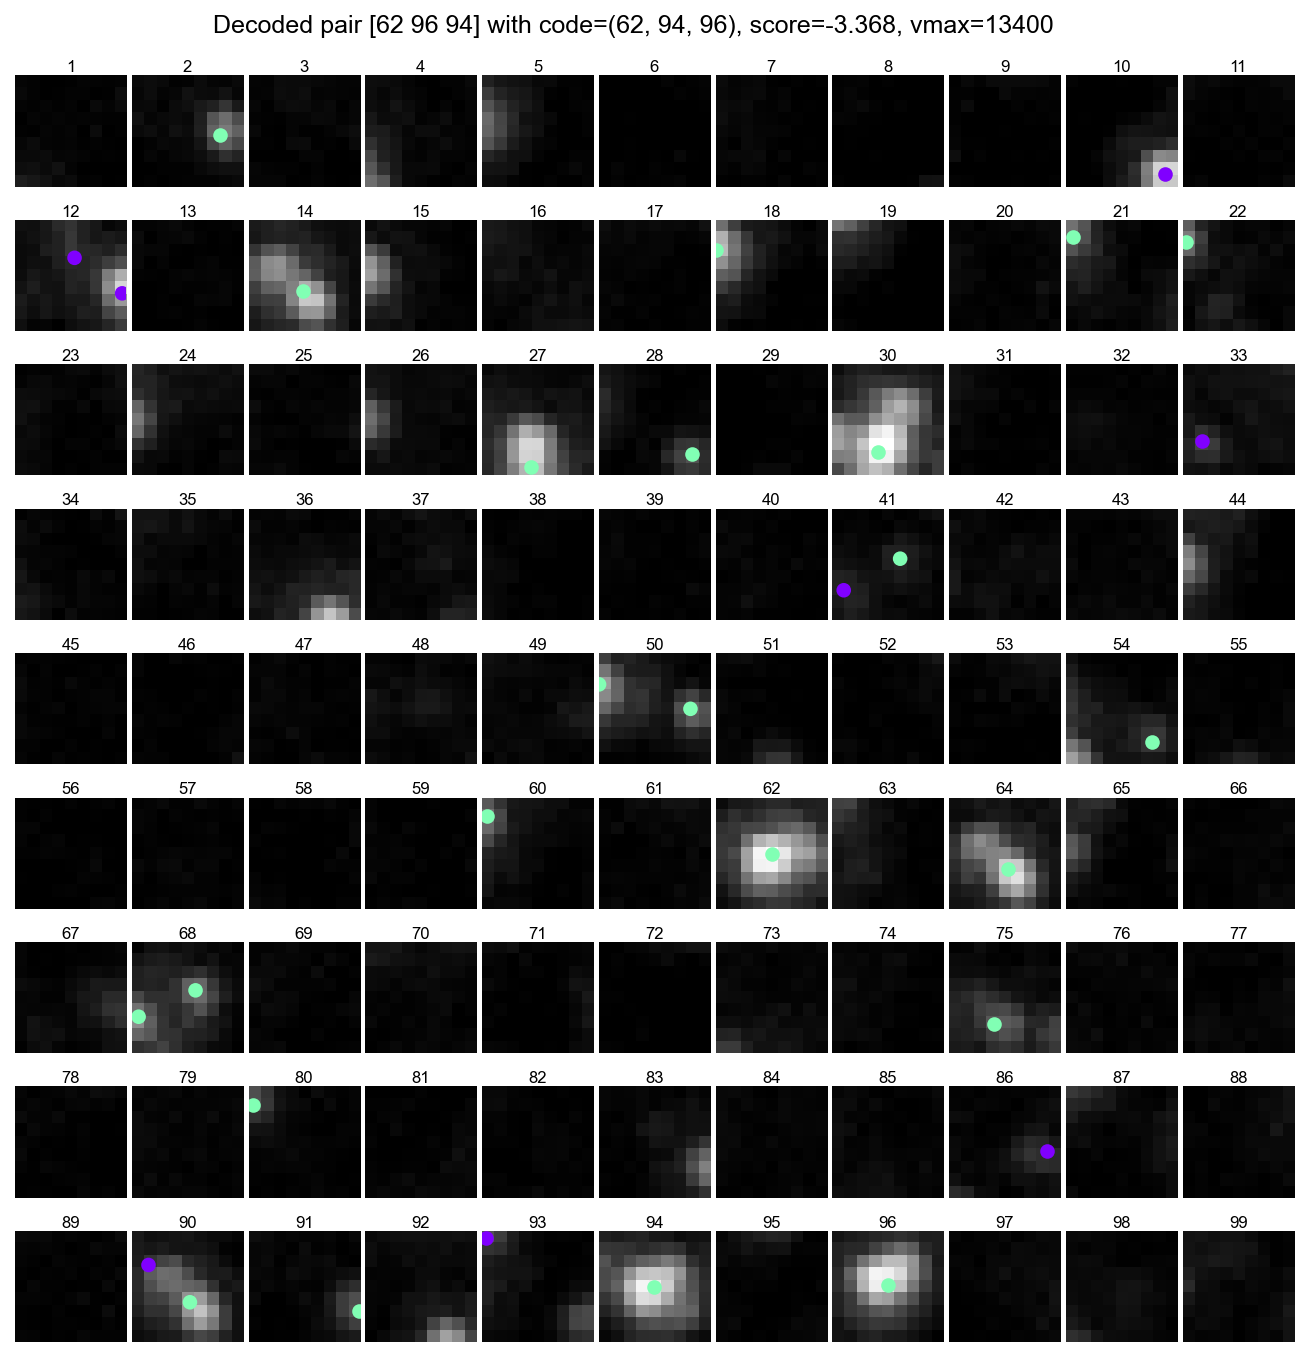

In [224]:
%matplotlib inline
from ImageAnalysis3.figure_tools import plot_decode
reload(plot_decode)

ax_list = plot_decode.plot_decoding_ims(combo_ids, cropped_ims, _sel_bit_2_coords,_sel_bit_2_usage,
                                        title=_title, max_th=max_th, 
                                        save=False,
                                        save_filename = decode_fig_filename,
                                        show_image=False)

In [194]:
%matplotlib notebook

def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')

_zxys_list = decoder.chr_2_zxys_list['2']

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               cmap=Spectral, 
               c=Spectral(_ichr/(len(_zxys_list)+1)),
               #c=homolog_labels,
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
fig.show()

<IPython.core.display.Javascript object>

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


## 4.3 process all

In [195]:
%%time
# old version
import multiprocessing as mp

print(len(decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

150
Wall time: 4min 38s


# 5. Summarize decoder

In [196]:
#decoder_folder = os.path.join(save_folder, 'Decoder')
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in os.listdir(decoder_folder) 
                if _fl.split(os.path.extsep)[-1]=='pkl']
print(decoder_folder, len(decoder_filenames))

\\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Decoder\v5 128


In [197]:
%%time
import multiprocessing as mp
load_args = [(_fl, 'chr_2_zxys_list') for _fl in decoder_filenames]
print(len(load_args))
with mp.Pool(44) as load_pool:
    all_chr_2_zxys_list = load_pool.starmap(decode.batch_load_attr, 
                                            load_args, chunksize=1)
    load_pool.close()
    load_pool.join()
    load_pool.terminate()

# summarize
decode_filenames = [_fl for _fl,_item in zip(decoder_filenames, all_chr_2_zxys_list) if _item is not None]
all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
print(len(all_chr_2_zxys_list))

128
128
Wall time: 10.1 s


In [198]:
%%time
import multiprocessing as mp
summary_args = [(_item, codebook_df) for _item in all_chr_2_zxys_list ]

print(len(summary_args))

with mp.Pool(44) as summary_pool: 
    all_zxys_list = summary_pool.starmap(decode.DNA_Merfish_Decoder.summarize_zxys_by_regions, 
                                         summary_args, chunksize=1)
    summary_pool.close()
    summary_pool.join()
    summary_pool.terminate()

128
Wall time: 15.9 s


<IPython.core.display.Javascript object>


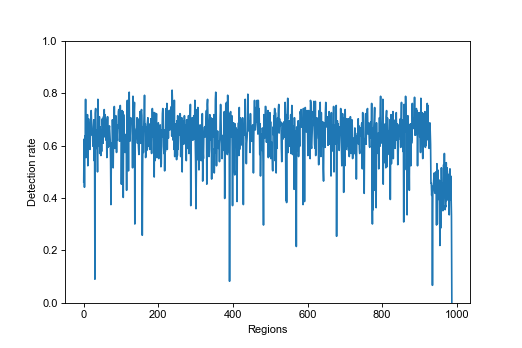

In [207]:
all_zxys = np.concatenate(all_zxys_list)
loss_rates = np.mean(np.isnan(all_zxys).any(2), axis=0)
plt.figure()
plt.plot(1-loss_rates)
plt.ylim([0,1])
plt.xlabel('Regions')
plt.ylabel('Detection rate')
plt.show()

In [209]:
%%time
from scipy.spatial.distance import cdist,pdist,squareform
from tqdm import tqdm

all_zxys = np.concatenate(all_zxys_list)
#all_zxys = np.array(decode_save_dict['zxys'])

all_distmaps = [squareform(pdist(_zxys)) for _zxys in tqdm(all_zxys)]

from ImageAnalysis3.classes import postanalysis
median_distmap = postanalysis.parallel_reduce_matrix(all_distmaps, function='nanmedian', axis=0,
                                                     num_threads=44)


100%|█████████████████████████████████████████████████████████████████████| 256/256 [00:04<00:00, 58.06it/s]


Wall time: 15.1 s


In [210]:
%%time
all_contactmaps = np.array(all_distmaps) <= 0.5

contactmap = postanalysis.parallel_reduce_matrix(all_contactmaps, function='nanmean', axis=0,
                                                     num_threads=44)

Wall time: 4.63 s


In [211]:
save_figure = True
#figure_folder = os.path.join(save_folder, 'Figures_final')
figure_folder = os.path.join(decoder_folder, 'Figures_final')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")

Create figure_folder: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Decoder\v5\Figures_final


In [214]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  


<IPython.core.display.Javascript object>


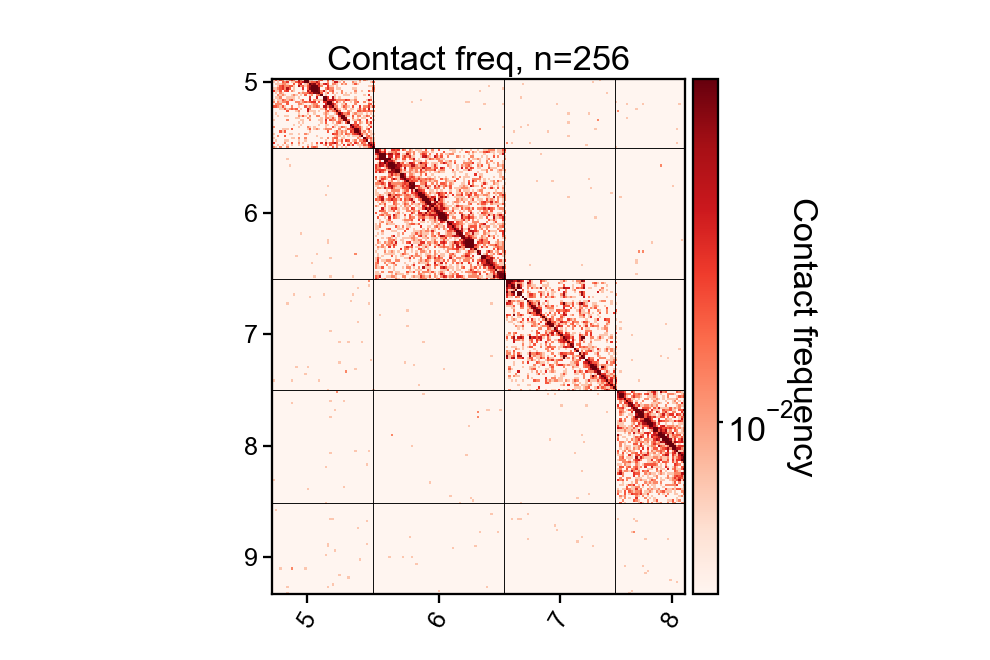

In [215]:
from matplotlib.colors import LogNorm
from matplotlib import cm

contact_limits = [0.005, 0.04]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = cm.get_cmap('Reds')
contact_cmap.set_bad(color=[0.,0.,0.,1])

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(
    contactmap, 
    cmap=contact_cmap,
    color_limits=contact_limits,
    color_norm=contact_norm,
    colorbar_labels='Contact frequency',
    ax=ax,
)

ax.set_title(f'Contact freq, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_contact_map.png'), transparent=True)
fig.show()


<IPython.core.display.Javascript object>


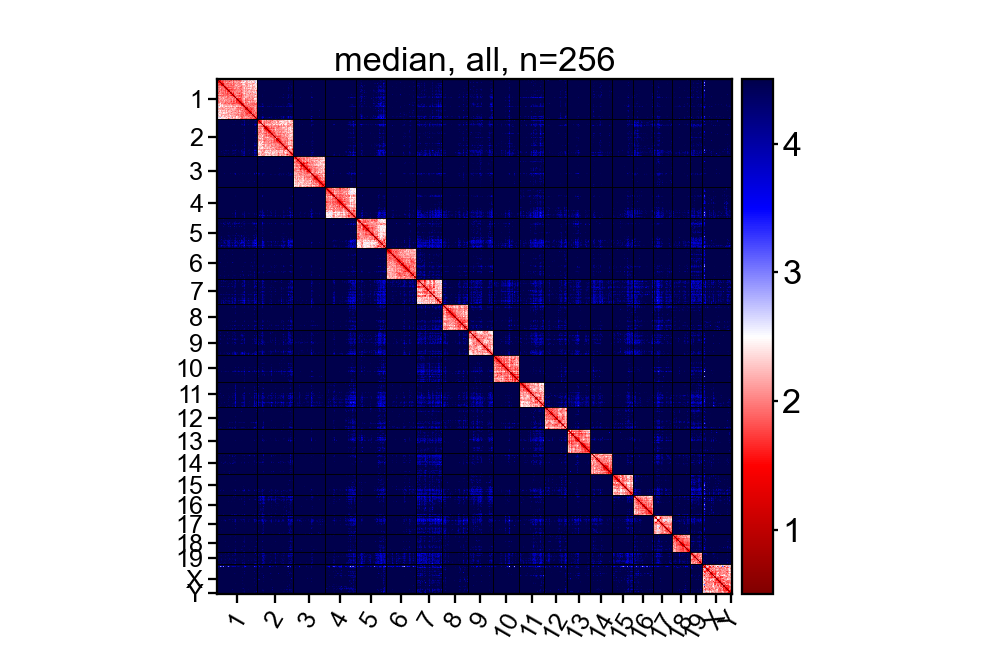

In [219]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(median_distmap, color_limits=[0.5,4.5],
                                          ax=ax,
                                          )
ax.set_title(f'median, all, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_median_distmap.png'), transparent=True)
fig.show()